In [33]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [34]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [35]:
!ls

kaggle.json  sample_data


In [36]:
!cat kaggle.json

{"username":"bsridevi","key":"4e6615b72e240572dae32149f48a799c"}

In [37]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [38]:
#Download data
!kaggle competitions download -c quora-question-pairs

 57% 12.0M/21.2M [00:00<00:00, 26.7MB/s]
100% 21.2M/21.2M [00:00<00:00, 53.6MB/s]
100% 4.95M/4.95M [00:00<00:00, 36.1MB/s]

 92% 105M/114M [00:02<00:00, 36.1MB/s] 
100% 114M/114M [00:03<00:00, 39.4MB/s]
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [39]:
!unzip -q train.csv.zip -d .


In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
#import distance
from nltk.stem import PorterStemmer
#from bs4 import BeautifulSoup

In [41]:

df = pd.read_csv("/content/train.csv",encoding='latin-1')
df = df.fillna('')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [42]:
df.shape

(404290, 6)

In [43]:
print("No.of data points : ", df.shape[0])

No.of data points :  404290


In [44]:
df.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [45]:
df[df["question1"].isnull()]

,id,qid1,qid2,question1,question2,is_duplicate


In [46]:
df[df["question2"].isnull()]

,id,qid1,qid2,question1,question2,is_duplicate


In [47]:
df[df["is_duplicate"].isnull()]

,id,qid1,qid2,question1,question2,is_duplicate


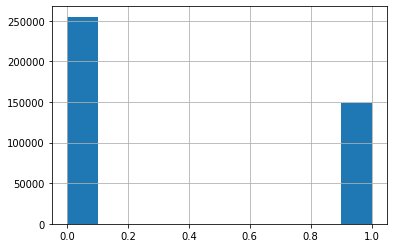

In [48]:
df["is_duplicate"].hist()

In [49]:
!python -m spacy download en


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [50]:
import spacy

In [51]:
spacy_text = spacy.load('en')


In [52]:


import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy import data
from torchtext.legacy.data import Field, BucketIterator


In [53]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


In [54]:
def tokenize_text(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_text.tokenizer(text)]

In [55]:
Q1 = Field(tokenize = tokenize_text,
           init_token = '<sos>',
           eos_token = '<eos>',
           lower = True,
           batch_first = True)

Q2 = Field(tokenize = tokenize_text,
           init_token = '<sos>',
           eos_token = '<eos>',
           lower = True,
           batch_first = True)

In [56]:
LABEL = data.LabelField(dtype = torch.float)

In [57]:
fields = [('q1', Q1), ('q2', Q2), ('label', LABEL)]

In [58]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [59]:
df['question1'][10]

'Method to find separation of slits using fresnel biprism?'

In [60]:
df.shape[0]

404290

In [61]:
example = [torchtext.legacy.data.Example.fromlist([df.question1[i], df.question2[i], df.is_duplicate[i]], fields) for i in range(df.shape[0])]


In [62]:
Dataset = torchtext.legacy.data.Dataset(example, fields)


In [63]:
import random

In [64]:
(train_data, valid_data) = Dataset.split(split_ratio= [0.7, 0.3], random_state = random.seed(SEED))
len(train_data), len(valid_data)

(283003, 121287)

In [65]:
vars(train_data.examples[2])


{'label': 0,
 'q1': ['which',
  'leaf',
  'is',
  'necessary',
  'for',
  'green',
  'tea',
  '?',
  'what',
  'are',
  'different',
  'types',
  'of',
  'green',
  'tea',
  '?'],
 'q2': ['is', 'technology', 'making', 'people', 'ruder', '?']}

In [67]:
MAX_VOCAB_SIZE = 25_000

Q1.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
Q2.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

we have to build vocabulary on both

In [68]:

print(f"Unique tokens in Question 1 vocabulary: {len(Q1.vocab)}")
print(f"Unique tokens in Question 2 vocabulary: {len(Q2.vocab)}")
print(f"Unique tokens in Label vocabulary: {len(LABEL.vocab)}")

Unique tokens in Question 1 vocabulary: 25004
Unique tokens in Question 2 vocabulary: 25004
Unique tokens in Label vocabulary: 2


In [69]:
print(Q1.vocab.freqs.most_common(20))


[('?', 297199), ('the', 131944), ('what', 114214), ('is', 94200), ('how', 76809), ('i', 73861), ('a', 71042), ('to', 69433), ('in', 68663), ('do', 57960), ('of', 55833), ('are', 51947), ('and', 46723), ('can', 39565), ('for', 36309), (',', 34264), ('you', 32434), ('why', 29357), ('it', 24067), ('best', 23870)]


In [70]:
print(Q2.vocab.freqs.most_common(20))


[('?', 299092), ('the', 131940), ('what', 112672), ('is', 95486), ('i', 82208), ('how', 78088), ('a', 76505), ('to', 74969), ('in', 69297), ('do', 60819), ('of', 55967), ('are', 50712), ('and', 46569), ('can', 40803), ('for', 36947), (',', 34559), ('you', 32602), ('why', 29353), ('my', 26058), ('it', 25659)]


In [71]:
print(LABEL.vocab.freqs.most_common(20))


[(0, 178313), (1, 104690)]


In [72]:
print(vars(train_data[10]))

{'q1': ['is', 'nothing', 'free', 'in', 'this', 'world', '?'], 'q2': ['why', 'is', 'nothing', 'free', 'in', 'this', 'world', '?'], 'label': 0}


In [73]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, valid_data), 
    batch_size = BATCH_SIZE,
    device = device)

In [74]:
import torch.nn as nn

class Encoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx ):
    
    super().__init__()
    
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)

    self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, text):
    embedded = self.dropout(self.embedding(text))
    #packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
    outputs, (hidden, cell) = self.lstm(embedded)
    #output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

    hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
    return self.fc(hidden)



In [75]:
class SiameseLSTM(nn.Module):
  def __init__(self, encoder, device):
    super().__init__()
    self.encoder1 = encoder
    self.encoder2 = encoder
    self.device = device
  def forward(self, q1, q2):
    output1 = self.encoder1(q1)
    output2 = self.encoder2(q2)

    print(output1.shape, output2.shape)

    #distance
    dist = torch.sum(torch.abs(output1 - output2), dim=1, keepdim=True)
    return dist


In [76]:
INPUT_DIM = len(Q1.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 256
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = Q1.vocab.stoi[Q1.pad_token]

enc = Encoder(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM,
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)


In [77]:
model = SiameseLSTM(enc, device)

In [78]:
model.to(device)

SiameseLSTM(
  (encoder1): Encoder(
    (embedding): Embedding(25004, 100, padding_idx=1)
    (lstm): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (encoder2): Encoder(
    (embedding): Embedding(25004, 100, padding_idx=1)
    (lstm): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [79]:

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

SiameseLSTM(
  (encoder1): Encoder(
    (embedding): Embedding(25004, 100, padding_idx=1)
    (lstm): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (encoder2): Encoder(
    (embedding): Embedding(25004, 100, padding_idx=1)
    (lstm): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [80]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,941,872 trainable parameters


In [81]:
optimizer = optim.Adam(model.parameters())


In [82]:
i, T = list(enumerate(train_iterator))[3]

In [83]:
i, T

(3, 
 [torchtext.legacy.data.batch.Batch of size 64]
 	[.q1]:[torch.LongTensor of size 64x41]
 	[.q2]:[torch.LongTensor of size 64x41]
 	[.label]:[torch.FloatTensor of size 64])

In [84]:
type(T)

torchtext.legacy.data.batch.Batch

In [85]:
T.q1.shape

torch.Size([64, 41])

In [86]:
T.q2.shape

torch.Size([64, 41])

In [87]:
T.q1[0]

tensor([    2,     6,     7,     5, 10611,   171,    11,   221,     4,     3,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1])

In [88]:
T.q2[0]

tensor([    2,     6,    15,    33,    14,     5, 12799,    67,   136,     4,
            3,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1])

In [89]:
(T.q1[0].shape, T.q2[0].shape)

(torch.Size([41]), torch.Size([41]))

In [90]:
(T.q1.shape, T.q2.shape)

(torch.Size([64, 41]), torch.Size([64, 41]))

In [91]:
maxsize = max(T.q1[0].shape, T.q2[0].shape)
maxsize

torch.Size([41])

In [92]:
if T.q1.shape[1] < maxsize[0]:
  print("padding q1")
  to_be_padded_shape = ( T.q1.shape[0], maxsize[0] - T.q1.shape[1])
  padding = torch.zeros(to_be_padded_shape, dtype=torch.int64)
  T.q1 = torch.cat((T.q1, padding), dim=1)
else:
  print("padding q2")
  to_be_padded_shape = ( T.q2.shape[0], maxsize[0] - T.q2.shape[1])
  padding = torch.zeros(to_be_padded_shape, dtype=torch.int64)
  T.q2 = torch.cat((T.q2, padding), dim=1)


padding q2


In [93]:
T.q1.shape, T.q2.shape, padding.shape

(torch.Size([64, 41]), torch.Size([64, 41]), torch.Size([64, 0]))

In [94]:
T.q2[0].dtype

torch.int64

In [95]:
outcome = model(T.q1, T.q2)

torch.Size([41, 256]) torch.Size([41, 256])


In [96]:
outcome

tensor([[12.2315],
        [12.1437],
        [13.2439],
        [12.5394],
        [13.2348],
        [12.3255],
        [12.6842],
        [12.9157],
        [11.7978],
        [11.5629],
        [11.7352],
        [11.6193],
        [12.1877],
        [11.8261],
        [13.1125],
        [13.2358],
        [13.0227],
        [14.3568],
        [12.4816],
        [13.6343],
        [12.0443],
        [13.8672],
        [12.5225],
        [13.1863],
        [13.9998],
        [11.6921],
        [13.5412],
        [11.6467],
        [13.8298],
        [13.9510],
        [11.4053],
        [14.2877],
        [12.5663],
        [12.0089],
        [13.2093],
        [12.4435],
        [13.0460],
        [12.8072],
        [12.6689],
        [12.0312],
        [12.1303]], grad_fn=<SumBackward1>)

In [ ]:
T.label

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 0.])